## mel spec demo

In [1]:
# Miscellaneous
import os
import glob
import time
from natsort import natsorted

# Scientific
import numpy as np
import scipy
import librosa
from skimage.transform import resize
from beatbrain.metrics import ncc
from beatbrain import utils

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from beatbrain.display import show_spec

In [8]:
def show_audio(audio, **kwargs):
    ipd.display(ipd.Audio(audio, **kwargs))

In [5]:
AUDIO_PATH = "/home/cds_data/fma/audio/test/006/006329.mp3"

In [6]:
#AUDIO_PATH = "../data/fma/audio/000/000005.mp3"
START = 0
DURATION = 5
SAMPLE_RATE = 32768
N_FFT = 4096
HOP_LENGTH = 256
N_MELS = 512
CHUNK_SIZE = 640
RESAMPLE_TYPE = 'kaiser_fast'

In [9]:
audio, sr = librosa.load(AUDIO_PATH, sr=SAMPLE_RATE,
                         offset=START, duration=DURATION,
                         res_type=RESAMPLE_TYPE)
show_audio(audio, rate=sr)

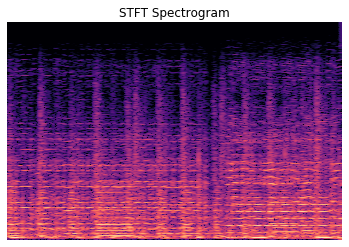

In [10]:
spec = np.abs(librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
show_spec(spec, scale_fn=librosa.amplitude_to_db, title="STFT Spectrogram")

In [ ]:
#get rif of the those less than 5s long
y, sr = librosa.load(filename, offset=5*i, duration=5.0)

## prep data load from local

In [2]:
from pathlib import Path
import pandas as pd
metadata = Path("/home/cds_data/fma/metadata")
tracks = pd.read_csv(metadata.joinpath('tracks.csv'), header=[0, 1, 2])
tracks = tracks.droplevel(2, axis=1)
tracks.columns = tracks.columns.set_levels(['track_id', *tracks.columns.levels[0][1:]], level=0)
tracks.columns = tracks.columns.set_levels(['', *tracks.columns.levels[1][1:]], level=1)
tracks.set_index("track_id", inplace=True)
tracks = tracks[tracks["set", "subset"] == "small"]  # Only include songs from fma_small dataset
tracks = tracks[pd.notnull(tracks["track", "genre_top"])] 

In [3]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

6400 training examples, 800 validation examples, 800 testing examples


In [4]:
tracks=tracks.drop(['album', 'artist'], axis=1)

In [5]:
tracks.loc[2]["set"]["split"]

'training'

In [6]:
tracks.loc[2]["track"]["genre_top"]

'Hip-Hop'

In [7]:
set(tracks['track', 'genre_top'])#8 classes

{'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock'}

In [24]:
npz=utils.load_arrays("/home/cds_data/fma/numpy/000/000002.npz")
npz[-1].shape#(band,time)

(512, 640)

In [13]:
"/home/cds_data/fma/numpy/006/006677.npz"[-10:-4]

'006677'

## ML

In [ ]:
import numpy as np
##########prep data#########################
X=[]
Y=[]
####normalize
#_min,_max=float('inf'),-float('inf')

for fpath in glob.glob('/home/cds_data/fma/numpy/*/*'):
    #based on track_id get test/val/train
    track_id=int(fpath[-10:-4])
    ########use fma predefined split####
    #split=tracks.loc[track_id]["set"]["split"]
    genre=tracks.loc[track_id]["track"]["genre_top"]
    #load data
    nps=utils.load_arrays(fpath)
    for npz in nps:
        #mean
        f1=np.mean(npz,axis=0)
        #median
        f2=np.std(npz, axis=0)
        #std
        f3=np.median(npz,axis=0)
        #append 
        npz=(np.concatenate((f1, f2))),f3
        X.append(npz)
        Y.append(genre)
        ###########normalize code(unused)
        #_min=min(np.amin(np),_min)
        #_max=max(np.amix(np),_max)
#prep all data
X,Y=np.array(X),np.array(Y)
#####normalize(unused)
#X=(X-_min)/(_max-_min)

In [ ]:
#change y to categorical int
lookupTable, Y = np.unique(Y, return_inverse=True)

In [38]:
np.save('X.npy', X) # save
np.save('Y.npy', Y)

## logistic regression

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,
random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1.0, multi_class='auto', solver='lbfgs')
model.fit(X_train, y_train) # Training the model
y_pred = model.predict(X_test) # Predicting labels for our test set using trained
evaluate_on_training_set(y_test, y_pred) 

## SVM

In [ ]:
from sklearn.svm import SVC
model = SVC(C=10, gamma='auto', kernel='rbf')
model.fit(X_train, y_train)
model.fit(X_train, y_train) # Training SVM
y_pred = model.predict(X_test) # Predicting labels for our test set using trained
evaluate_on_training_set(y_test, y_pred) #

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20) #
model.fit(X_, y_train) # Training the model
# Evaluate the model:
y_pred = model.predict(X_test) # Predicting labels for our test set using trained
evaluate_on_training_set(y_test, y_pred)

## Guassian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train) # Training the model
y_pred = model.predict(X_test) # Predicting labels for our test set using trained
evaluate_on_training_set(y_test, y_pred)
model.fit(X_train, y_train) # Training the model
y_pred = model.predict(X_test) # Predicting labels for our test set using trained
evaluate_on_training_set(y_test, y_pred)

## DL

In [ ]:
#####data processing######
import numpy as np
X=[]
Y=[]
####normalize
_min,_max=float('inf'),-float('inf')
for fpath in glob.glob('/home/cds_data/fma/numpy/*/*'):
    #based on track_id get test/val/train
    track_id=int(fpath[-10:-4])
    ########use fma predefined split####
    #split=tracks.loc[track_id]["set"]["split"]
    genre=tracks.loc[track_id]["track"]["genre_top"]
    #load data
    nps=utils.load_arrays(fpath)
    for npz in nps:
        X.append(npz)
        Y.append(genre)
        ###########normalize code(unused)
        _min=min(np.amin(np),_min)
        _max=max(np.amix(np),_max)
#prep all data
X,Y=np.array(X),np.array(Y)
#####normalize(unused)
X=(X-_min)/(_max-_min)

In [ ]:
#change y to categorical int
lookupTable, Y = np.unique(Y, return_inverse=True)

In [ ]:
np.save('X_dl.npy', X) # save
np.save('Y_dl.npy', Y)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import pickle

## Recurrent

In [ ]:
def get_recurrent_model():
    #shape of RNN (n,time,feat)
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activtion="relu")))
    model.add(TimeDistributed(Dense(32,activtion="relu")))
    model.add(TimeDistributed(Dense(16,activtion="relu")))
    model.add(TimeDistributed(Dense(8,activtion="relu")))
    model.add(Flatten())
    model.add(Dense(10,activation="softmax"))
    model.summary()
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
    return model

In [ ]:
############# for rec ############################
X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
y_flat=np.argmax(y,axis=1)
input_shape=(X.shape[1],X.shape[2])

model=get_recurrent_model()
###train and evel
class_weight=compute_class_weight("balanced",np.unique(y),y_flat)
checkpoint=ModelCheckpoint("cov.model",monitor="val_acc",verbose=1,mode="max",
                           save_best_only=True,save_weights_only=False,periods=1)
model.fit(X,y,epoch=10,batch_size=32,shuffle=True,
          validation_split=0.1,callbacks=[checkpoint])
model.save("re.model")

## Conv

In [ ]:
def get_conv_model():
    model=Sequential()
    model.add(Conv2D(16,(3,3),activation="relu",strides=(1,1),padding="same"))
    model.add(Conv2D(16,(3,3),activation="relu",strides=(1,1),padding="same"))
    model.add(Conv2D(16,(3,3),activation="relu",strides=(1,1),padding="same"))
    model.add(Conv2D(16,(3,3),activation="relu",strides=(1,1),padding="same"))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(10,activation="softmax"))
    model.summary()
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
    return model

In [ ]:
############for conv ##########################
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y_flat=np.argmax(y,axis=1)
input_shape=(X.shape[1],X.shape[2],1)

model=get_conv_model()
###train and evel
class_weight=compute_class_weight("balanced",np.unique(y),y_flat)
checkpoint=ModelCheckpoint("conv.model",monitor="val_acc",verbose=1,mode="max",
                           save_best_only=True,save_weights_only=False,periods=1)
model.fit(X,y,epoch=10,batch_size=32,shuffle=True,
          validation_split=0.1,callbacks=[checkpoint])
model.save("conv.model")